In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# k-means简介

最优的聚类结果需符合以下两个假设
- “簇中心点”是属于该簇的所有数据点坐标的算数平均值
- 一个簇的每个点到该中心点的距离，比到其他簇中心点的距离短

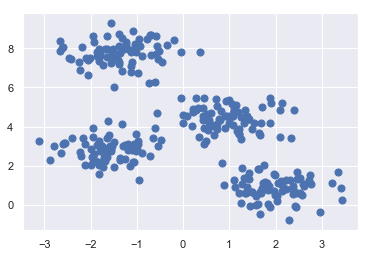

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, 
                       centers=4,
                       cluster_std=0.60,
                       random_state=0)
plt.scatter(X[:, 0], X[:, 1], 
            s=50) # 大小

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

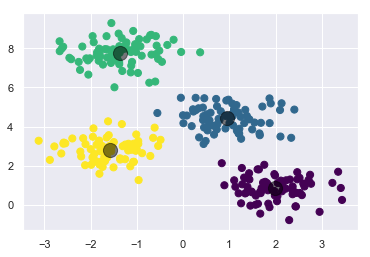

In [4]:
plt.scatter(X[:, 0], X[:, 1], 
            c=y_kmeans, # 颜色
            s=50, # 大小
            cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            c='black', # 颜色
            s=200, # 大小
            alpha=0.5) # 透明度

# k-means算法：期望最大化

期望最大化方法的步骤：
1. 猜测一些簇中心点
2. 重复直至收敛
    1. **期望步骤**（E-step）：将点分配至离其最近的簇中心点
    2. **最大化步骤**（M-step）：将簇中心点设置为所有点坐标的平均值

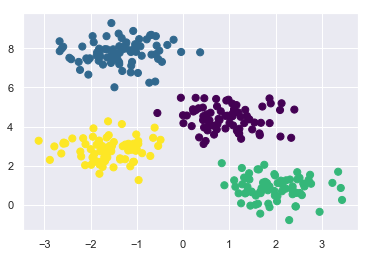

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. 随机选择簇中心点
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. 基于最近的中心点指定标签
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. 根据点的平均值找到新的中心点
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. 确认收敛
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], 
            c=labels,
            s=50,
            cmap='viridis')

使用期望最大化算法时的注意事项：
1. 可能不会达到全局最优解

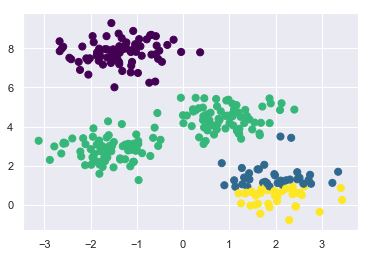

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], 
            c=labels,
            s=50,
            cmap='viridis')

2. 簇数据必须事先定好

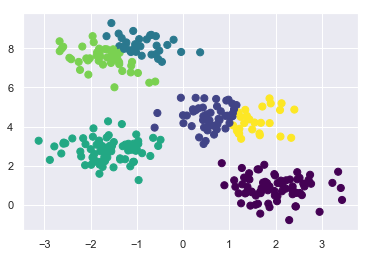

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1],
            c=labels,
            s=50,
            cmap='viridis')

3. k-means算法只能确定线性聚类边界

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=0.05, random_state=0)

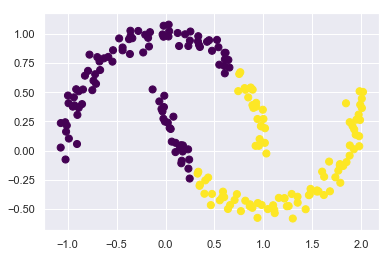

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1],
            c=labels,
            s=50,
            cmap='viridis')

C:\Users\z\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


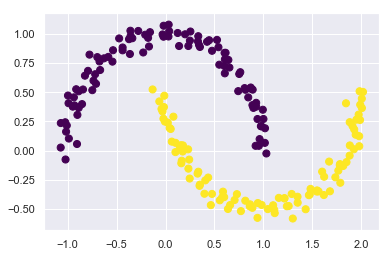

In [10]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2,
                           affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1],
            c=labels,
            s=50,
            cmap='viridis')

4. 当数据量较大时，k-means会很慢

# 案例

## 案例1：用k-means算法处理手写数字

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

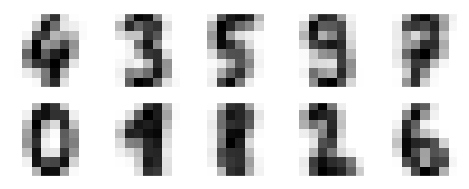

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

Text(89.18, 0.5, 'predicted label')

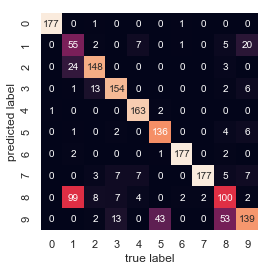

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [17]:
from sklearn.manifold import TSNE

# 投影数据：这一步将耽误几秒钟
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# j计算类
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# 排列标签
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
# 计算准确度
accuracy_score(digits.target, labels)

0.9398998330550918

## 案例2：将k-means用于色彩压缩

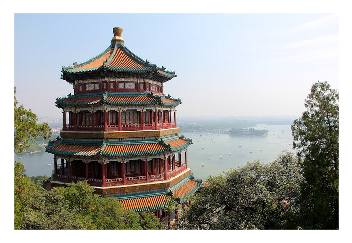

In [18]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

In [19]:
china.shape

(427, 640, 3)

In [20]:
data =china / 255.0 # 转换成0-1区间值
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [21]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
        
    # 随机选择一个子集
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green',
              xlim=(0, 1), ylim=(0, 1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', 
              xlim=(0, 1), ylim=(0, 1))
    
    fig.suptitle(title, size=20)

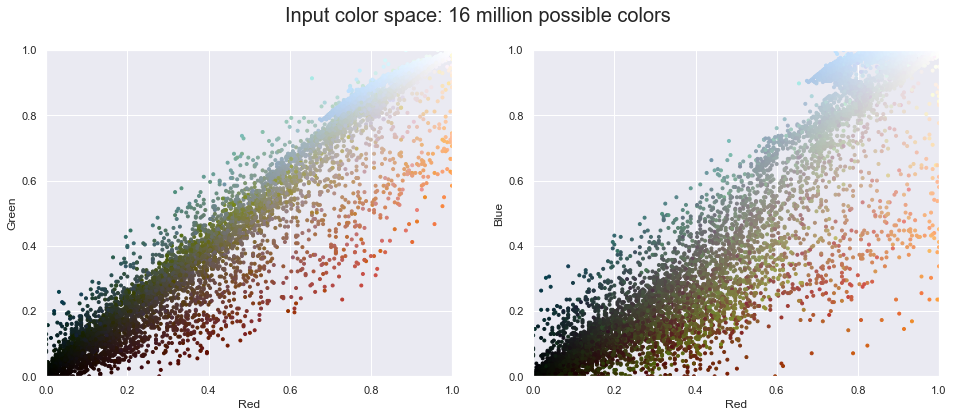

In [22]:
plot_pixels(data, title='Input color space: 16 million possible colors')

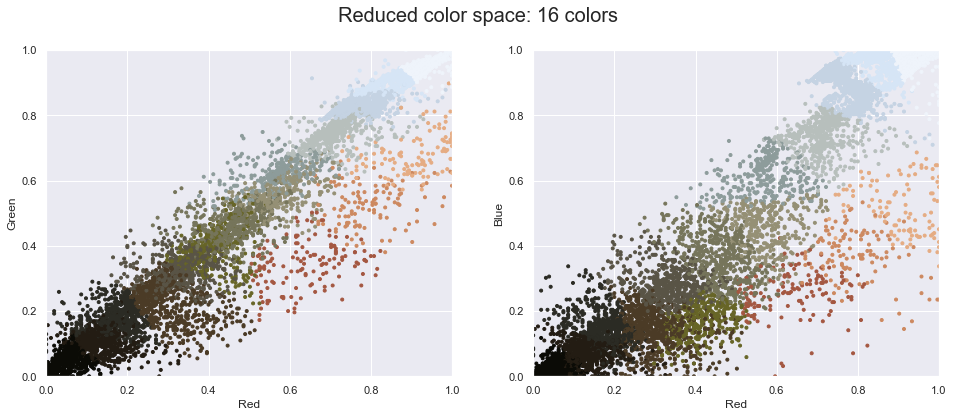

In [23]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title='Reduced color space: 16 colors')

Text(0.5, 1.0, '16-color Image')

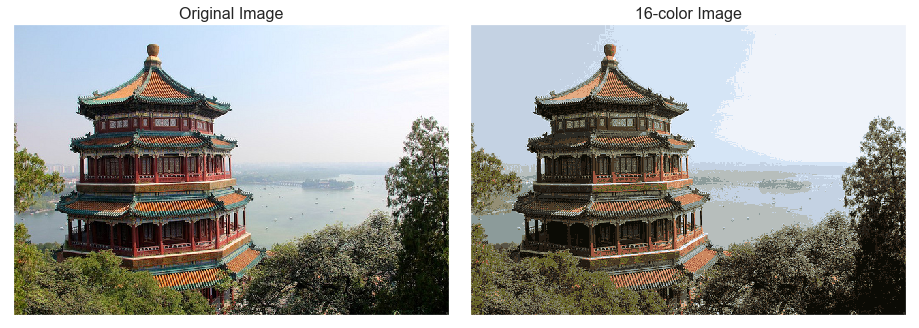

In [24]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), 
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)